# 3D (x-y-t) field generation and lagrangian simulation

This example will cover:

 - Generation of a synthetic x-y-t field
 - Simulation of drifter trajectories

Prerequisite, have parcels installed, see [OceanParcels doc](https://oceanparcels.org).
If under conda environment: `conda install -c conda-forge parcels`

In [1]:
import os
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import xrft

from gptide import cov
from gptide import GPtideScipy
from gptide import stats as gpstats

import utils as ut
day = 86400

data_dir = "data/"
data_dir = "/home1/scratch/aponte/"
data_dir = "/home/datawork-lops-osi/aponte/nwa/drifter_stats"

store = True

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41005,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:45406,Total threads: 7
Dashboard: http://127.0.0.1:41162/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:46646,


## Generate velocity fields

The different flow formulations considered are:

1. direct velocity field generation: $u$ and $v$ specified independantly and with separable autocorrelations (x/y/t).
2. streamfunction and potential field generation: $u=-\partial_y \psi + \partial_x \phi$ and $v=\partial_x \psi + \partial_y \phi$, where $\psi$ and $\phi$ are independent fields with separable autocorrelations.

**Points addressed:**

- kinetic energy spectral slopes need to match general expectation of isotropic wavenumber spectral slope between -3 and -2.
- separability implies non-isotropic spatial spectra and weird deformation (e.g. vorticity, divergence) fields, we opt for isotropic formulation

**Points to potentially in the future address:**

- $\psi$ $\phi$ correlations have been considered in the past, see mention of spirality in [Wang and Buhler 2021]
- could we make the problem 2D periodic?

**Note:** Link Matern parameters ($\nu$, n=1) to spectral slope $s$ ($k^{-s}$): $s=2\nu+n$.

In [3]:
#### 
# Input parameters

# signal characteristics
U = .2     # amplitude m/s (will be rescale for streamfunction/potential amplitudes)
#U = 2.     # amplitude m/s (will be rescale for streamfunction/potential amplitudes)
#U = .02     # amplitude m/s (will be rescale for streamfunction/potential amplitudes)
λx = 100   # km
λy = 100   # km
λt = 5     # days

# noise:
#noise = 0.01
noise = 0. # noise will be added to observations just before inference

# velocity field formulation
#kind = "uv"
kind, pp_ratio = "pp", 0.

# covariance mode
#Cmodel=("matern2_iso", "matern12")
Cmodel=("matern32_iso", "matern12")

# Grid parameters: size, spacing
Nx, dx = 1000, 1.  # km
Ny, dy = 1000, 1.  # km
Nt, dt = 100*24, 1/24  # days

### dev
#λx = 10   # km
#λy = 10   # km
#Nx = 100
#Ny = 50
#Nt = 10*2

# rescale grid parameters for some models
if "iso" in Cmodel[0]:
    factor = 10
    Nx //= factor
    Ny //= factor
    dx *= factor  # km
    dy *= factor  # km

In [4]:
### velocity field formulation

if kind=="uv":
    # u-v formulation
    η = U
    amplitudes = (η, η)
    suffix = kind
elif kind=="pp":
    # psi-phi field formulation
    #λ = np.sqrt(λx**2 + λy**2)
    λ = λx
    if "matern32" in Cmodel[0]:
        ν = 3/2
    else:
        assert False, "implement scaling factor"
    η = np.sqrt((ν-1)/ν)*U*λ
    amplitudes = (η*(1-pp_ratio), η*pp_ratio)
    #scale = λ*0.5
    #amplitudes = (scale * amplitudes[0], scale * amplitudes[1])

In [5]:
# assemble prefix and parameters for storage

#suffix = "_".join([Cmodel[0], Cmodel[1],kind, f"r{pp_ratio}"])
suffix = "_".join([Cmodel[0], Cmodel[1], kind, f"r{pp_ratio}_u{U}"])

params = dict(
    U = U,
    eta = η,
    lambda_x = λx,
    lambda_y = λy, 
    lambda_t = λt,
    cov_x = Cmodel[0],
    cov_y = Cmodel[0],
    cov_t = Cmodel[1],
    kind = kind,
    amplitude0 = amplitudes[0],
    amplitude1 = amplitudes[1],
    pp_ratio = pp_ratio,
    noise = noise,
)

print(suffix)
params

matern32_iso_matern12_pp_r0.0_u0.2


{'U': 0.2,
 'eta': 11.547005383792515,
 'lambda_x': 100,
 'lambda_y': 100,
 'lambda_t': 5,
 'cov_x': 'matern32_iso',
 'cov_y': 'matern32_iso',
 'cov_t': 'matern12',
 'kind': 'pp',
 'amplitude0': 11.547005383792515,
 'amplitude1': 0.0,
 'pp_ratio': 0.0,
 'noise': 0.0}

### start assembling covariances

In [6]:
# actually generate covariances
C, X, N, isotropy = ut.generate_covariances(Cmodel, Nx, Ny, Nt, dx, dy, dt, λx, λy, λt)

# add jitter on diagonal or get at cholesky: LinAlgError: Matrix is not positive definite
jitter = 1e-6
if len(C)==2:
    C = C[0], C[1]+jitter*np.eye(*C[1].shape)
elif len(C)==3:
    C = C[0], C[1], C[2]+jitter*np.eye(*C[2].shape)

Covariance models: space=matern32_iso , time=matern12


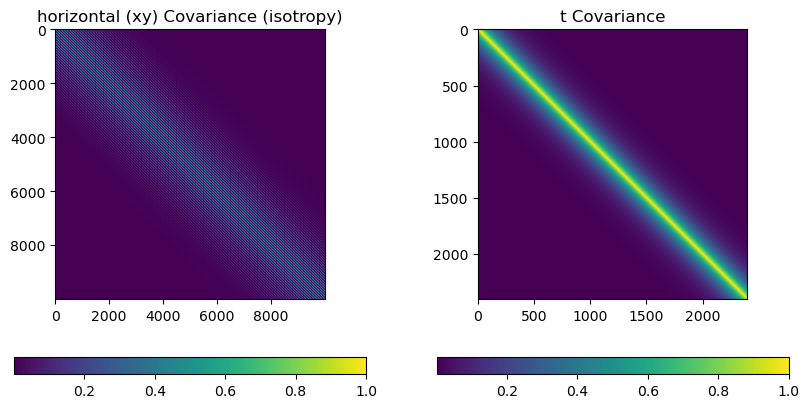

In [7]:
if len(C)==3:
    
    Cov_x, Cov_y, Cov_t = C
    
    fig, axes = plt.subplots(1,3, figsize=(10,5))

    ax = axes[0]
    h = ax.imshow(Cov_x)
    #h = ax.imshow(Cov_d)
    plt.colorbar(h, location="bottom")
    ax.set_title("x Covariance")

    ax = axes[1]
    h = ax.imshow(Cov_y)
    plt.colorbar(h, location="bottom")
    ax.set_title("y Covariance")

    ax = axes[2]
    h = ax.imshow(Cov_t)
    plt.colorbar(h, location="bottom")
    ax.set_title("t Covariance")
    
if len(C)==2:
    
    Cov_d, Cov_t = C
    
    fig, axes = plt.subplots(1,2, figsize=(10,5))

    ax = axes[0]
    h = ax.imshow(Cov_d)
    #h = ax.imshow(Cov_d)
    plt.colorbar(h, location="bottom")
    ax.set_title("horizontal (xy) Covariance (isotropy)")

    ax = axes[1]
    h = ax.imshow(Cov_t)
    plt.colorbar(h, location="bottom")
    ax.set_title("t Covariance")

## sample generation

In [8]:
#ds = ut.generate_uv(kind, N, C, X, amplitudes, noise, time=False, isotropy=isotropy) # dev
ds = ut.generate_uv(kind, N, C, X, amplitudes, noise, time=True, isotropy=isotropy)
ds.attrs.update(**params)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/dask/array/routines.py:328: PerformanceWarning: Increasing number of chunks by factor of 480
  intermediate = blockwise(
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/dask/array/routines.py:328: PerformanceWarning: Increasing number of chunks by factor of 480
  intermediate = blockwise(


In [9]:
if store:
    ds.to_zarr(os.path.join(data_dir, "3D_"+suffix+"_flow.zarr"), mode="w")

distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

### reload and plot

In [10]:
ds = xr.open_zarr(os.path.join(data_dir, "3D_"+suffix+"_flow.zarr"), decode_times=False)

In [11]:
# verifies flow amplitude on full dataset
float(ds["U"].std()), float(ds["V"].std())

(0.1791268066416047, 0.17614170467454493)

In [13]:
# on snapshot
_ds = ds.isel(time=0).persist()
float(_ds["U"].std()), float(_ds["V"].std())

(0.1710220455555062, 0.1823653499833538)

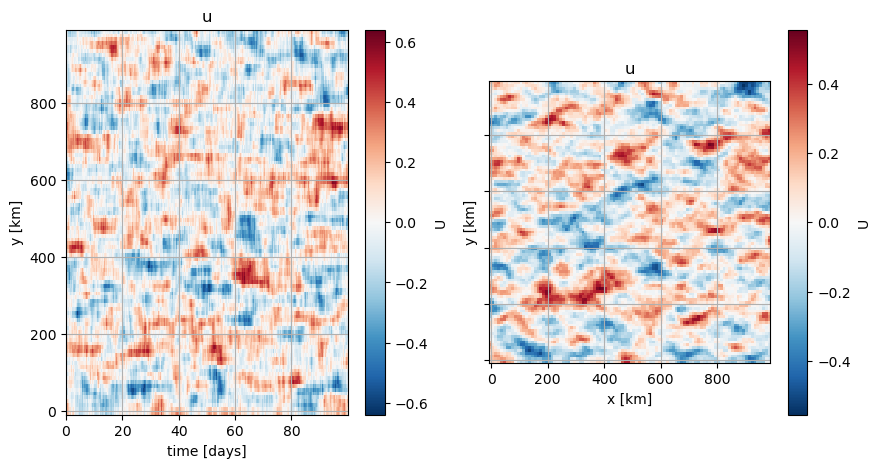

In [14]:
fig, axes = plt.subplots(1,2,figsize=(10,5), sharey=True)

ax = axes[0]
ds.U.isel(x=ds.x.size//2).plot(ax=ax, x="time", y="y")
ax.grid()
ax.set_title("u")

ax = axes[1]
ds.U.isel(time=0).plot(ax=ax, x="x", y="y")
ax.grid()
ax.set_title("u")
ax.set_aspect("equal")

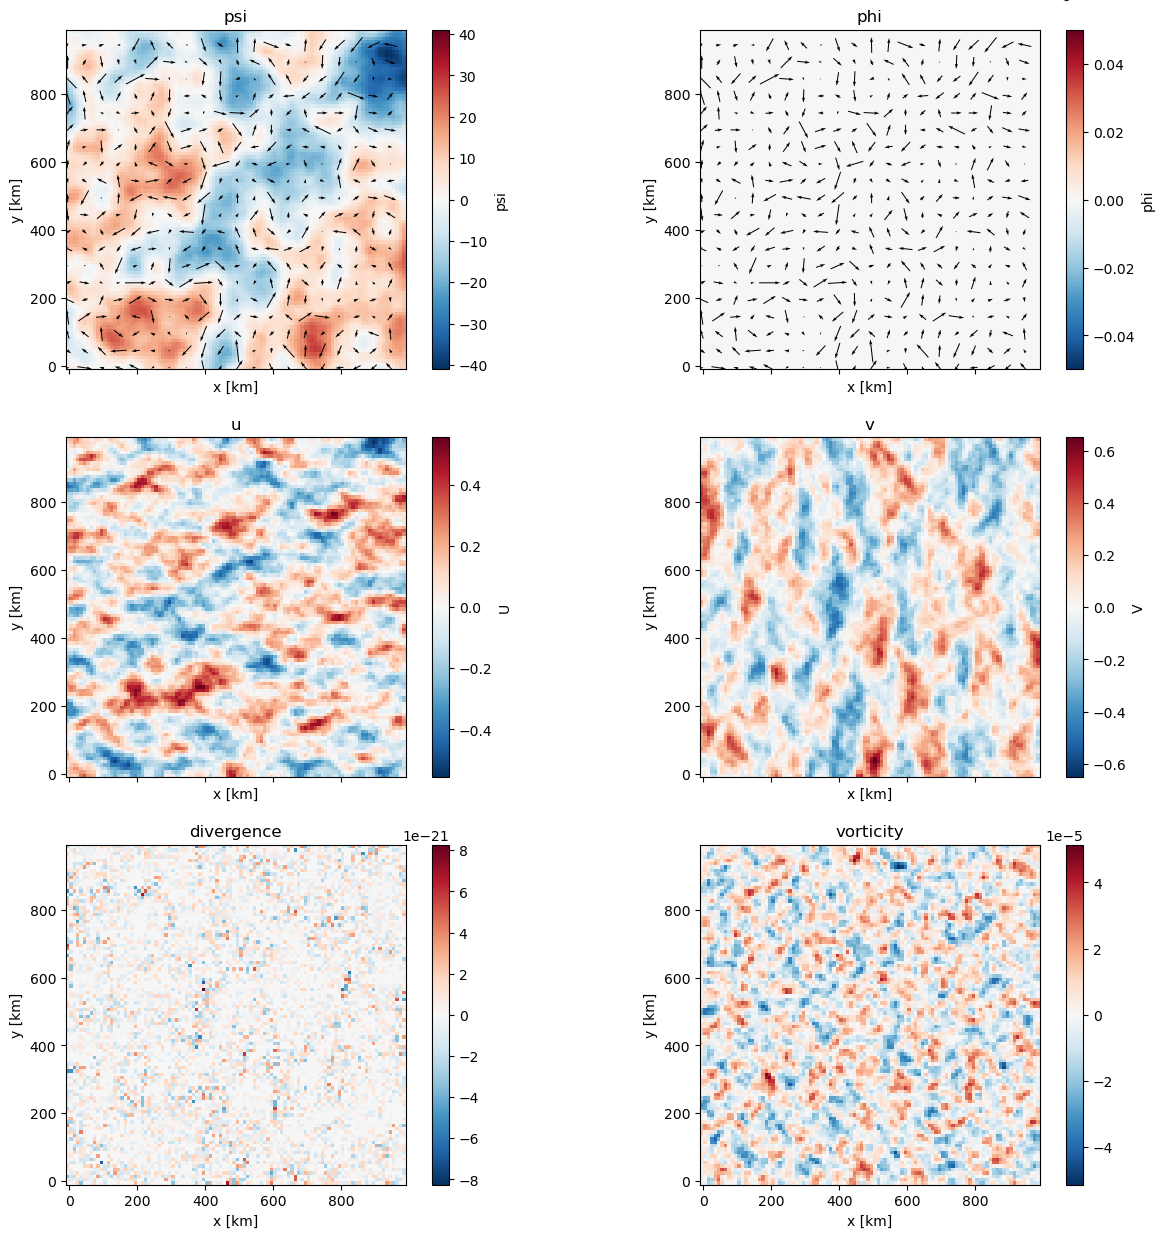

In [15]:
ut.plot_snapshot(_ds, darrow=5);

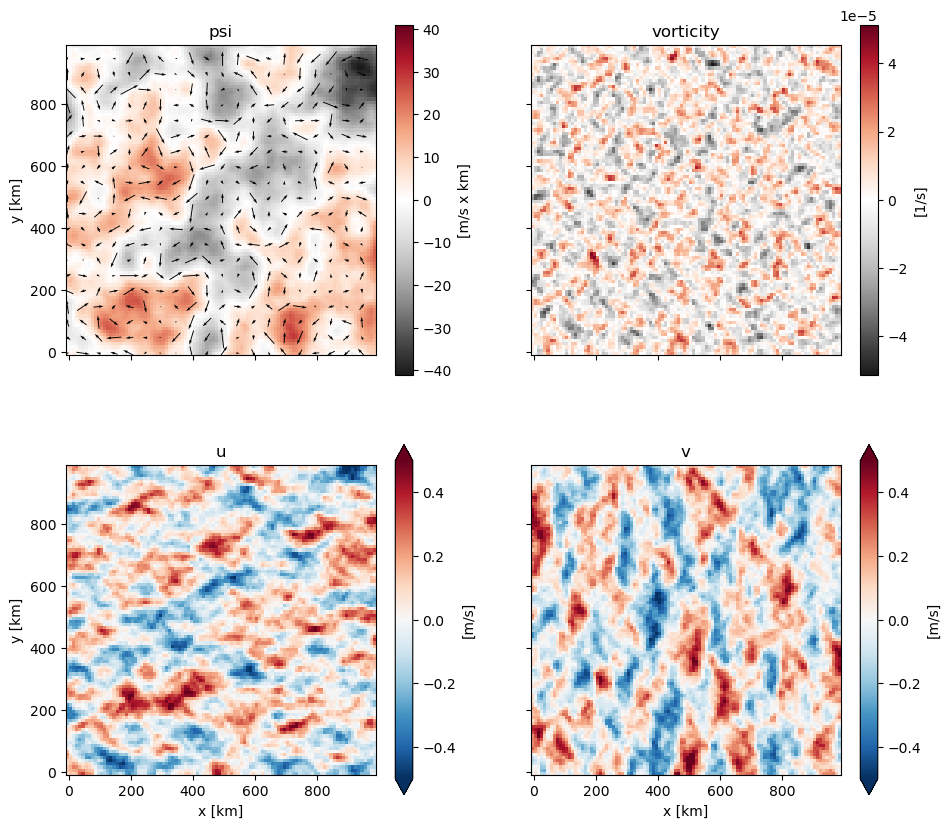

In [16]:
def plot_snapshot_vortical(ds, darrow=20):
    
    fig, axes = plt.subplots(2,2,figsize=(11,10), sharex=True, sharey=True)
    
    dsa = ds.isel(x=slice(0,None,darrow), y=slice(0,None,darrow))

    ax = axes[0, 0]
    ds.psi.plot(ax=ax, cmap="RdGy_r", cbar_kwargs={'label': "[m/s x km]"})
    dsa.plot.quiver("x", "y", "U", "V", ax=ax, add_guide = False)
    ax.set_aspect("equal")
    ax.set_title("psi")
    ax.set_xlabel("")
    
    ## velocities
    u_scale = 0.5

    ax = axes[1, 0]
    ds.U.plot(ax=ax, cmap="RdBu_r", cbar_kwargs={'label': "[m/s]"}, vmax=u_scale)
    #dsa.plot.quiver("x", "y", "U", "V", ax=ax)
    ax.set_aspect("equal")
    ax.set_title("u")
    
    ax = axes[1, 1]
    ds.V.plot(ax=ax, cmap="RdBu_r", cbar_kwargs={'label': "[m/s]"}, vmax=u_scale)
    #dsa.plot.quiver("x", "y", "U", "V", ax=ax)
    ax.set_aspect("equal")
    ax.set_title("v")
    ax.set_ylabel("")
    
    ##
    vorticity = ds.V.differentiate("x")/1e3 - ds.U.differentiate("y")/1e3
    
    ax = axes[0, 1]
    vorticity.plot(ax=ax, cmap="RdGy_r", cbar_kwargs={'label': "[1/s]"})
    #dsa.plot.quiver("x", "y", "U", "V", ax=ax)
    ax.set_aspect("equal")
    ax.set_title("vorticity")    
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    return fig, axes

plot_snapshot_vortical(_ds, darrow=5);

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


<xarray.DataArray (freq_r: 17)>
dask.array<getitem, shape=(17,), dtype=float64, chunksize=(17,), chunktype=numpy.ndarray>
Coordinates:
    time     float64 -0.02083
  * freq_r   (freq_r) float64 0.001874 0.0044 0.00716 ... 0.04385 0.04669


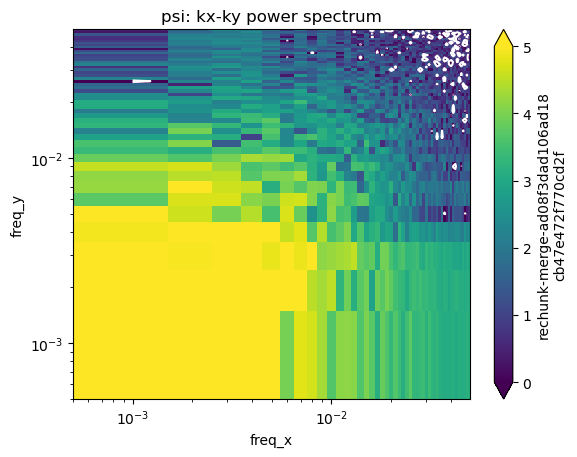

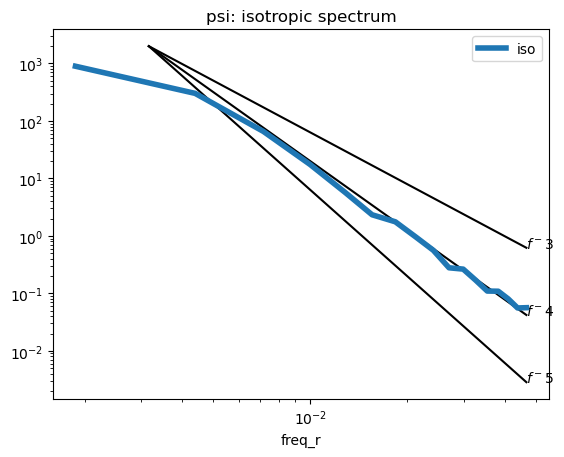

In [17]:
ut.plot_spectra(_ds, "psi", yref=2e3, vmin=0, vmax=5, slopes=[-3,-4,-5])

### temporal spectra

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


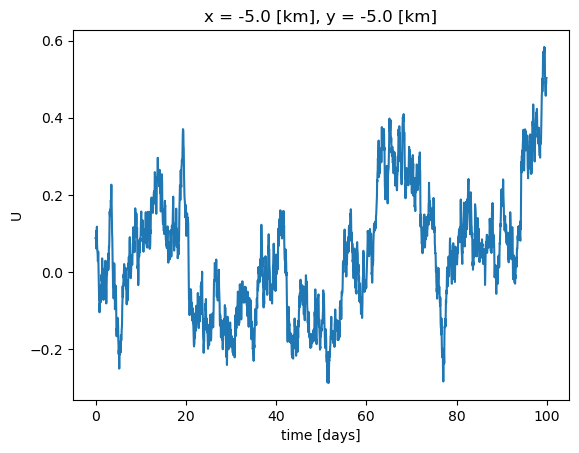

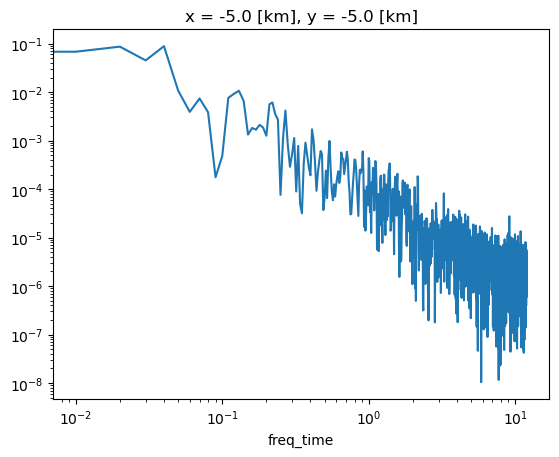

In [18]:
_ds = ds.isel(x=0, y=0).compute()
_ds.U.plot()

E = xrft.power_spectrum(_ds["U"], dim=['time'], detrend='linear', window=True)

fig, ax = plt.subplots(1,1)
E.plot()
ax.set_xscale("log")
ax.set_yscale("log")

## setup parcels

In [12]:
from datetime import timedelta

import xarray as xr

from parcels import (
    AdvectionRK4,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
    plotTrajectoriesFile,
)

In [13]:
# assemble Field set
ds = xr.open_zarr(os.path.join(data_dir, "3D_"+suffix+"_flow.zarr"), decode_times=False)
ds["x"] = ds["x"]*1e3 # rescale in m
ds["y"] = ds["y"]*1e3 # rescale in m
ds = ds.rename(x="lon", y="lat")
ds["time"] = ds["time"]*day # rescale in seconds
ds["time"].attrs.update(units="seconds")

nb = 2
bounds = (float(ds["lon"].values[0])  + nb*dx*1e3,
          float(ds["lon"].values[-1]) - nb*dx*1e3,
          float(ds["lat"].values[0])  + nb*dy*1e3,
          float(ds["lat"].values[-1]) - nb*dy*1e3,
)

fieldset = FieldSet.from_xarray_dataset(
    ds,
    variables=dict(U="U", V="V"),
    dimensions=dict(lon="lon", lat="lat", time="time"),                         
    mesh="flat",
)

In [14]:
# create Particle set
_ds = ds.isel(lon=slice(10,-10,1), lat=slice(10,-10,1)) # coarse grid
#_ds = ds.isel(lon=slice(10,-10,10), lat=slice(10,-10,10))
x0 = (_ds.lon   + _ds.lat*0).values.flatten()
y0 = (_ds.lon*0 + _ds.lat  ).values.flatten()

pset = ParticleSet.from_list(
    fieldset=fieldset,  # the fields on which the particles are advected
    pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
    lon=x0,  # a vector of release longitudes
    lat=y0,  # a vector of release latitudes
    #time=t0,
)

In [15]:
#print(pset)

In [16]:
#pset.show(field=fieldset.U)

In [17]:
nc = os.path.join(data_dir, "3D_"+suffix+"_parcels.nc")

output_file = pset.ParticleFile(
    name=nc,  # the file name
    outputdt=timedelta(hours=1),  # the time step of the outputs
)

Tmax = np.floor(float(max(ds["time"]/day)))

# deal with boundaries
fieldset.add_constant('b0', bounds[0])
fieldset.add_constant('b1', bounds[1])
fieldset.add_constant('b2', bounds[2])
fieldset.add_constant('b3', bounds[3])
def StopParticle(particle, fieldset, time):
    # https://github.com/OceanParcels/parcels/blob/bf98c977a260afd86e91ce7af8f3af7dfef90edf/docs/examples/example_stommel.py#L86
    # https://docs.oceanparcels.org/en/latest/reference/particles.html#module-parcels.particle
    #if (particle.lon < bounds[0]) or (particle.lon > bounds[1]) or (particle.lat < bounds[2]) or (particle.lat > bounds[2]):
    if (particle.lon < fieldset.b0) or (particle.lon > fieldset.b1) \
        or (particle.lat < fieldset.b2) or (particle.lat > fieldset.b3):
        particle.delete()

pset.execute(
    AdvectionRK4+pset.Kernel(StopParticle),  # the kernel (which defines how particles move)
    #AdvectionRK4,  # the kernel (which defines how particles move)
    runtime=timedelta(days=Tmax),  # the total length of the run
    dt=timedelta(minutes=30),  # the timestep of the kernel
    #dt=timedelta(minutes=30),  # the timestep of the kernel
    output_file=output_file,
)

INFO: Compiled ArrayJITParticleAdvectionRK4StopParticle ==> /dev/shm/pbs.6361094.datarmor0/parcels-55081/libecbedef71becaddbcda2adbf4574c2e6_0.so
INFO: Temporary output files are stored in /home/datawork-lops-osi/aponte/nwa/drifter_stats/out-SZVPAXOJ.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/datawork-lops-osi/aponte/nwa/drifter_stats/out-SZVPAXOJ" to convert these to a NetCDF file during the run.
100% (8553600.0 of 8553600.0) |##########| Elapsed Time: 0:00:16 Time:  0:00:16


In [18]:
# necessary for older version of parcels (as old as 2.3.0 at least)
if store:
    output_file.export()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


### reload and plot

In [13]:
def massage_coords(ds):
    if "lon" in ds:
        ds = ds.rename(lon="x", lat="y")
        ds["x"] = ds["x"]/1e3
        ds["y"] = ds["y"]/1e3
    ds.x.attrs.update(units="km", standard_name="x")
    ds.y.attrs.update(units="km", standard_name="y")
    if "t" in ds:
        ds.t.attrs.update(units="days")
    else:
        ds.time.attrs.update(units="days")
    return ds

In [14]:
# parcels dataset
#ds = xr.open_zarr(os.path.join(data_dir, "3D_"+suffix+"_parcels.zarr"))
ds = xr.open_dataset(os.path.join(data_dir, "3D_"+suffix+"_parcels.nc"))
ds = ds.drop("trajectory").rename_dims(dict(traj="trajectory")) # tmp
ds = ds.chunk(dict(trajectory=100, obs=-1))
ds = massage_coords(ds)
ds = ds.assign_coords(t=(ds["time"] - ds["time"][0,0])/pd.Timedelta("1D"))
ds = ds.compute()

# flow dataset
dsf = xr.open_zarr(os.path.join(data_dir, "3D_"+suffix+"_flow.zarr"), decode_times=False)
dsf = massage_coords(dsf)
dsf.U.attrs.update(units="m/s")
dsf.V.attrs.update(units="m/s")
dsf["speed"] = np.sqrt(dsf["U"]**2 + dsf["V"]**2)
dsf = dsf.persist()

print(f"Number of drifters = {ds.trajectory.size}")

Number of drifters = 6400


Text(0.5, 1.0, 't=0.02d - 640 out of 6400 drifters')

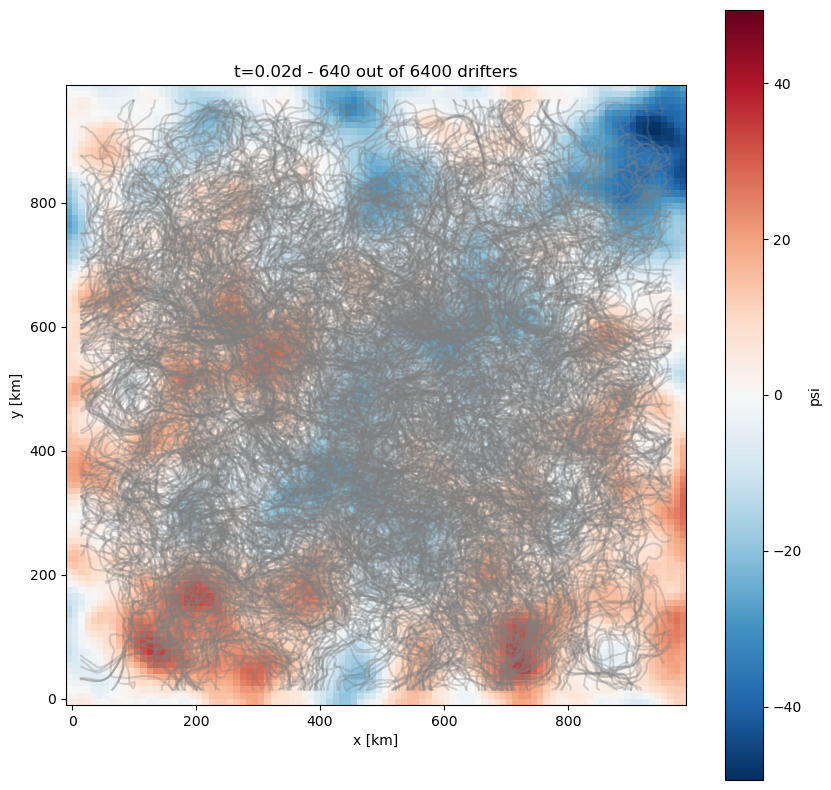

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

#v, cmap = "speed", "inferno"
v, cmap = "psi", "RdBu_r"
_da = dsf.isel(time=1)[v]
_da.plot(ax=ax, x="x", y="y", cmap=cmap)

_dsd = ds.isel(trajectory=slice(0,None,10))
for tr in _dsd.trajectory:
    _ds = _dsd.sel(trajectory=tr)
    ax.plot(_ds.x, _ds.y, color="0.5", alpha=.3)

ax.set_aspect("equal")
ax.set_title(f"t={float(_da.time):.2f}d - {_dsd.trajectory.size} out of {ds.trajectory.size} drifters")

## massage and store trajectories

In [16]:
# trajectory reaching the end of the simulation
def select_add_velocities(ds):
    maxt = ds.time.max("obs")
    n0 = ds.trajectory.size
    ds = ds.where( ~np.isnan(maxt), drop=True)
    ns = ds.trajectory.size
    print(f"{ns/n0*100:.1f}% of trajectories survived")
    #
    dt = ds.t.differentiate("obs")*day
    ds["u"] = ds.x.differentiate("obs")/dt*1e3 # x are in km
    ds["v"] = ds.y.differentiate("obs")/dt*1e3 # y are in km
    #
    t = ds.t
    #ds = ds.drop(["t", "time"])
    ds = ds.drop(["time"])
    ds["obs"] = ds.t.isel(trajectory=0)
    ds = ds.drop("t").rename(obs="time")

    return ds

ds_full = select_add_velocities(ds)

# randomly select 20 trajectories
narrow_selection = np.random.choice(ds_full.trajectory.values, 20)
dsn = ds_full.sel(trajectory=narrow_selection)

35.1% of trajectories survived


Text(0.5, 1.0, 'drifters not reaching boundaries')

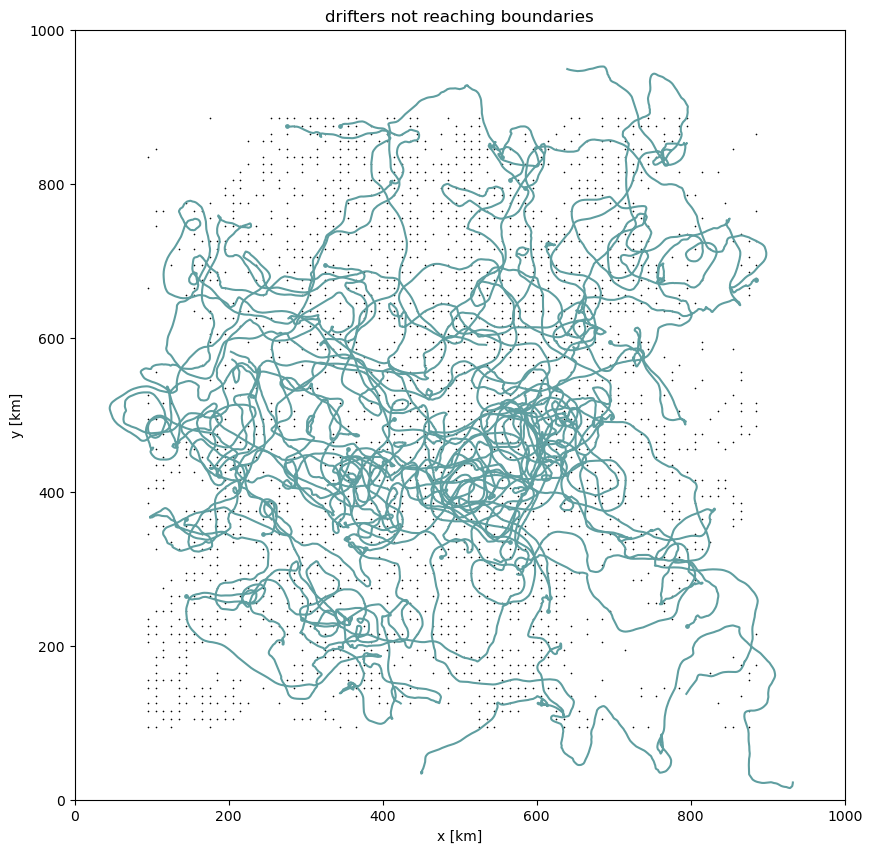

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ds_full.isel(time=[0]).plot.scatter(ax=ax, x="x", y="y", c="k", s=5)
dsn.isel(time=[0]).plot.scatter(ax=ax, x="x", y="y", c="cadetblue", s=20)
#dsn.plot.scatter(ax=ax, x="x", y="y", c="cadetblue", s=20)
ax.plot(dsn.x.T, dsn.y.T, color="cadetblue")

ax.set_aspect("equal")
ax.set_xlim(0,1000)
ax.set_ylim(0,1000)
ax.set_title("drifters not reaching boundaries")

Text(0.5, 1.0, 'u for a trajectory selection')

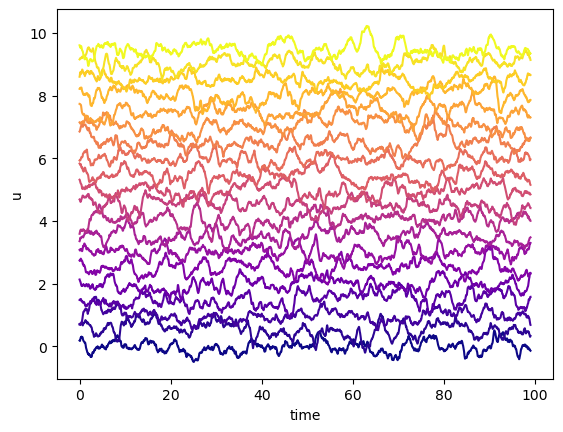

In [18]:
p = plt.get_cmap('plasma')
n = dsn.trajectory.size
for i, t in enumerate(dsn.trajectory):
    (dsn.sel(trajectory=t).u+i/2).plot(x="time", color=p(i/(n-1)))
ax.set_title("u for a trajectory selection")

In [19]:
# add attributes
dsn.attrs.update(**params)
dsn = dsn.drop("z")

In [20]:
if store:
    dsn.to_netcdf(os.path.join(data_dir,"3D_"+suffix+"_parcels_selection.nc"), mode="w")

In [21]:
dsf_sel = (dsf
    .sel(x=dsn.isel(time=0, drop=True).x, y=dsn.isel(time=0, drop=True).y, method="nearest")
    .drop("speed")
    .rename(U="u", V="v")
    .compute()
)
dsf_sel.attrs.update(**params)

In [28]:
if store:
    dsf_sel.to_netcdf(os.path.join(data_dir,"3D_"+suffix+"_flow_selection.nc"), mode="w")

### make movie

In [29]:
# add initial positions and transform in indexes: dangerous (assumes square grid)
dsxy = (ds
    .assign_coords(x0 = ds.x.isel(obs=0, drop=True), y0 = ds.y.isel(obs=0, drop=True))
    .set_index({"trajectory": ["x0", "y0"]})
    .unstack()
)
dsxy["t"] = dsxy["time"]/pd.Timedelta("1D")
dsxy = dsxy.drop("time")
#x0 = np.unique(ds.x0)
#y0 = np.unique(ds.y0)

In [30]:
fig_dir = "/Users/aponte/tmp/figs"
fig_dir = "/home1/scratch/aponte/figs" # datarmor

def plot_snapshot(o, i, v, vkwargs={}, trail=24, sel=None):

    t = float(ds.t.sel(obs=o).min())
    
    fig, ax = plt.subplots(1,1, figsize=(10,10))

    _da = dsf[v].interp(time=t)
    #_dsf = dsf.sel(time=t, method="nearest")
    dkwargs = dict(x="x", y="y", extend="neither")
    dkwargs.update(**vkwargs)
    if "levels" in dkwargs:
        _da.plot.contourf(ax=ax, **dkwargs)
    else:
        _da.plot(ax=ax, **dkwargs)
        
    #_ds = ds.isel(trajectory=slice(0,None,10))
    #_ds = ds.sel(obs=slice(o-trail, t))
    #_ds.plot.scatter(ax=ax, x="x", y="y", c="0.5", s=0.1)
    #for tr in ds.trajectory[::10]:
    for x, y in product(dsxy.x0[::5], dsxy.y0[::5]):
        _tr = dsxy.sel(x0=x, y0=y)
        _tr = _tr.where( (_tr.t<=t) & (_tr.t>=t-trail), drop=True)
        ax.plot(_tr.x, _tr.y, color="k", alpha=.5, lw=2)
        if _tr.x.size>0:
            ax.scatter(_tr.x[-1], _tr.y[-1], c="k", marker="o", s=3.)
    if sel is not None:
        for x, y, c in zip(sel["x"], sel["y"], sel["c"]):
            _tr = dsxy.sel(x0=x, y0=y) #, obs=slice(o-trail, o))
            _tr = _tr.where( (_tr.t<=t) & (_tr.t>=t-trail), drop=True)
            if _tr.x.size>0:
                ax.plot(_tr.x, _tr.y, color=c, alpha=1., lw=4)
                ax.scatter(_tr.x[-1], _tr.y[-1], c=c, marker="*", s=200., edgecolors="k", zorder=20)
    
    ax.set_aspect("equal")
    ax.set_title(f"t={t:.2f} d")
    
    fig_path = os.path.join(fig_dir, f"fig_{i:04}.png")
    fig.savefig(fig_path, dpi=150)
    # other relevant options: facecolor='w', bbox_inches = 'tight'
    plt.close(fig)

In [31]:
#v, cmap = "psi", "RdBu_r"
v, cmap = "psi", "RdYlBu_r"
#vkwargs = dict(cmap=cmap, levels=np.arange(-50,52,2), cbar_kwargs={'shrink':0.8})
vmax = η/0.2 * 50
vkwargs = dict(cmap=cmap, vmin=-vmax, vmax=vmax, cbar_kwargs={'shrink':0.8})

# selected trajectories
tr = dsn.trajectory[:3]
_ds = dsn.isel(time=0).sel(trajectory=tr)
sel = dict(tr=tr, x=_ds.x, y=_ds.y, c=["cadetblue", "blueviolet", "peru"])

#o, i = 10, 10
#for i, o in enumerate(tqdm(ds.obs.values[10:13])):
for i, o in enumerate(tqdm(ds.obs.values[::6])):
    plot_snapshot(o, i, v, vkwargs=vkwargs, trail=1., sel=sel)

100%|██████████| 397/397 [21:02<00:00,  3.18s/it]


To generate movie:

```
ffmpeg -framerate 10 -pattern_type glob -i "*.png" -c:v libx264 -pix_fmt yuv420p movie.mp4
```

Text(0, 0.5, '[m/s]')

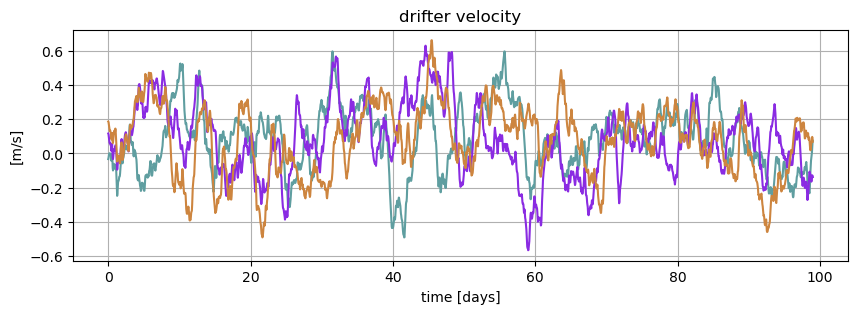

In [40]:
# drifter timeseries, matern12 in time

fig, ax = plt.subplots(1,1,figsize=(10,3))

for tr, x, y, c in zip(sel["tr"], sel["x"], sel["y"], sel["c"]):
    da = ds_full.sel(trajectory=tr)["u"]
    da.plot(ax=ax, color=c)
    
ax.grid()
ax.set_title("drifter velocity")
ax.set_xlabel("time [days]")
ax.set_ylabel("[m/s]")

365.0 835.0 cadetblue
525.0 385.0 blueviolet
355.0 285.0 peru


Text(0, 0.5, '[m/s]')

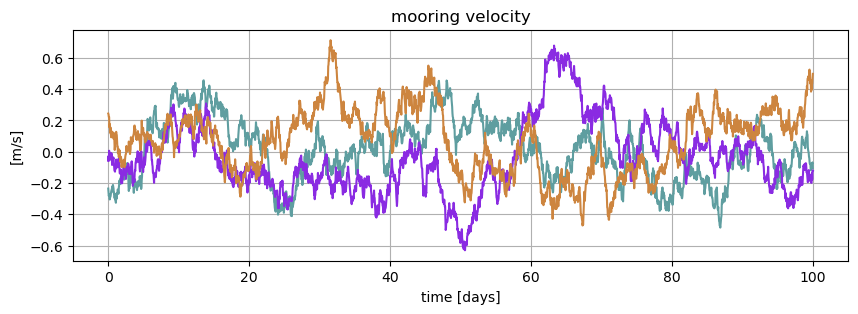

In [41]:
# mooring: matern12 in time

fig, ax = plt.subplots(1,1,figsize=(10,3))

_ds = dsf_sel.sel(trajectory=[0,1,2])

for tr, c in zip(_ds.trajectory, sel["c"]):
    da = _ds.sel(trajectory=tr)["u"]
    print(float(da.x), float(da.y), c)
    da.plot(ax=ax, color=c)
    
ax.grid()
ax.set_title("mooring velocity")
ax.set_xlabel("time [days]")
ax.set_ylabel("[m/s]")


In [ ]:
print(suffix)

---

## dev

In [ ]:
# for small size pb

zg_np = np.einsum("ij,kl,mn,jln->ikm", Lx, Ly, Lt, V.compute())

zg_da = da.einsum("ij,kl,mn,jln->ikm", Lx, Ly, Lt_dask, V).compute()

import opt_einsum as oe
zg_oe = oe.contract("ij,kl,mn,jln", Lx, Ly, Lt_dask, V).compute()


plt.imshow(zg_oe[...,0])
plt.colorbar()

plt.imshow(zg_oe[...,0] - zg_np[...,0])
plt.colorbar()

plt.imshow(zg_oe[...,0] - zg_da[...,0])
plt.colorbar()

In [ ]:
# inspect time increments of parcels output dataset
dt = (dsf.t.diff("obs").rename("dt")*24*60).round()
print(np.unique(dt)) # 30 or 60

traj_30 = list(ds.where(dt==30., drop=True).trajectory.values)
ds.sel(trajectory=traj_30[500]).t.diff("obs").plot() # last point may have 30min time increment

# conclusion: resample data before storing

In [ ]:
time = ds.time/pd.Timedelta("1H")
start = float(time.min(skipna=True))
end = float(time.max(skipna=True))
dt = float(time.diff("obs").median())
print(start, end, dt)

# potential common time line
t_target = np.arange(start, end+dt, dt)

def interpolate(ds):
    ds["obs"] = ds.time.squeeze()/pd.Timedelta("1H")
    ds = ds.where( ~np.isnan(ds.obs), drop=True)
    ds = ds.drop(["t", "time"])
    ds = ds.rename(obs="time")
    ds = ds.interp(time=t_target)
    #ds.interpolate
    return ds

# interpolate(ds.isel(trajectory=0))

# long if applied on full dataset
xr.concat([interpolate(dsf.isel(trajectory=i)) for i in range(dsf.trajectory.size)], "trajectory")